In [ ]:
import cv2
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow


In [ ]:
# Mount Google Drive (authentication required)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Blur Classification

import cv2
import numpy as np

def local_variance(image, neighborhood_size):
  """
  Calculates local variance of a grayscale image.

  Args:
      image: The grayscale image as a NumPy array.
      neighborhood_size: Size of the local neighborhood.

  Returns:
      A NumPy array containing the local variance for each pixel.
  """
  rows, cols = image.shape
  variance = np.zeros_like(image, dtype=np.float64)

  # Iterate over each pixel and calculate variance in its neighborhood
  for i in range(neighborhood_size // 2, rows - neighborhood_size // 2):
    for j in range(neighborhood_size // 2, cols - neighborhood_size // 2):
      neighborhood = image[i - neighborhood_size // 2 : i + neighborhood_size // 2 + 1,
                           j - neighborhood_size // 2 : j + neighborhood_size // 2 + 1]
      variance[i, j] = np.var(neighborhood)

  return variance

def analyze_blur_gaussian(image):
  """
  Analyzes image for Gaussian blur based on local variance distribution.

  Args:
      image: The input image as a NumPy array.

  Returns:
      True if Gaussian blur is likely, False otherwise.
  """
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Define neighborhood size for variance calculation
  neighborhood_size = 5

  # Calculate local variance
  variance = local_variance(gray, neighborhood_size)

  # Analyze variance distribution for Gaussian blur characteristics
  # - Relatively low variance overall
  # - Smooth transitions between regions of varying variance
  low_variance_ratio = np.count_nonzero(variance < variance.mean()) / variance.size
  smooth_transitions = cv2.Laplacian(variance, cv2.CV_64F).var() < 10  # Adjust threshold as needed

  return low_variance_ratio > 0.7 and smooth_transitions

def analyze_blur(image):
  """
  Analyzes blur type (Gaussian or motion) based on local variance.

  Args:
      image: The input image as a NumPy array.

  Returns:
      A string indicating "Gaussian blur", "Motion blur" (likely),
      or "Unknown blur" if inconclusive.
  """
  # Check for Gaussian blur first
  is_gaussian_blur = analyze_blur_gaussian(image)
  if is_gaussian_blur:
    return "Gaussian blur"
  else:
    # If not Gaussian, analyze for motion blur (using original approach)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    neighborhood_size = 5
    variance = local_variance(gray, neighborhood_size)
    high_variance_ratio = np.count_nonzero(variance > variance.mean()) / variance.size
    if high_variance_ratio > 0.2:
      return "Motion blur (likely)"
    else:
      return "Unknown blur"


In [ ]:
import scipy

def classify_image(image_path):
  """
  Classifies an image into blurry, noisy, or good based on Laplacian variance and standard deviation.

  Args:
      image_path (str): Path to the image file.

  Returns:
      str: Classification label ("blurry", "noisy", or "good").
  """

# Read image in grayscale (recommended)
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Check if image read successfully (optional, but good practice)
  if img is None:
      print("Error: Could not read image from", image_path)
      return None  # Or raise an exception

  # Display the image
  cv2_imshow(cv2.imread(image_path))


  # Calculate Laplacian variance for blur detection
  laplacian = cv2.Laplacian(img, cv2.CV_64F).var()
  print(laplacian)
  blur_threshold = 800  # Adjust based on image characteristics


  # Calculate standard deviation for noise detection
  std_dev = np.std(img)
  print(std_dev)
  noise_threshold = 55  # Adjust based on image characteristics

  result = ''
  blur = 0
  noise = 0

  # Classification logic
  if laplacian < blur_threshold:
    blur = 1
    result += " Blurry, "
    image = cv2.imread(image_path)
    result += " Blur Type " + analyze_blur(image)

  if std_dev > noise_threshold:
    noise = 1
    result += "|| Noisy, "
    #checking type of Noise
    # Flatten image data
    img_data = img.flatten()

    # Calculate kurtosis
    kurtosis = np.abs(scipy.stats.kurtosis(img_data))  # Import scipy.stats

    print(kurtosis)

    # Thresholds (adjust based on your observations)
    salt_pepper_threshold = 0.75  # High kurtosis for salt-and-pepper noise
    gaussian_threshold = 0.75  # Low kurtosis for Gaussian noise

    # Classification logic
    if kurtosis > salt_pepper_threshold:
      result += " Noise Type: Salt-and-Pepper"

    elif kurtosis < gaussian_threshold:
      result += " Noise Type: Gaussian"

    else:
      result += " Noise Type: Unknown"

  if blur == 0 and noise == 0:
    result = "Good"

  return result


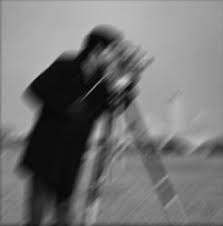

75.32225417538766
55.66237317588288
0.739856417328296
Image classification:  Blurry,  Blur Type Motion blur (likely)|| Noisy,  Noise Type: Gaussian


In [ ]:
# Example usage
image_path = "/content/gdrive/MyDrive/Sample Images/Motion Blur 1.jpeg"  # Replace with your correct image path
classification = classify_image(image_path)
if classification:  # Check if classification was successful
    print("Image classification:", classification)